In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm
import datetime
from matplotlib import pyplot as plt

%matplotlib inline
%run ./data_loading.ipynb

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=0)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=10*10*12, out_features=300)
        self.fc2 = nn.Linear(in_features=300, out_features=60)
        self.fc3 = nn.Linear(in_features=60, out_features=9)
        
    def forward(self, X):
        X = self.relu(self.conv1(X))
        X = self.pool(self.relu(self.conv2(X)))
        X = self.relu(self.conv3(X))
        X = self.pool(self.relu(self.conv4(X)))
        X = X.view(-1, 10*10*12)
        X = self.relu(self.fc1(X))
        X = self.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [3]:
def calculate_accuracy(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    return acc

In [4]:
def train(dataset, epochs, batch_size=5, to_cuda=True, calculate_acc=False):
    train_acc = []
    val_acc = []
    if to_cuda:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    else:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            if to_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_f(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print('epoch:', epoch, ', loss:', running_loss * batch_size / dataloader.__len__())
        if calculate_acc:
            t = calculate_accuracy(dataloader)
            v = calculate_accuracy(val_loader)
            print("train acc:", t, "val acc:", v)
            train_acc.append(t)
            val_acc.append(v)
        if epoch % 1 == 0: # every x epochs reshuffle data by creating a new loader
            if to_cuda:
                dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
            else:
                dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return train_acc[-1], val_acc[-1]

In [5]:
hyper_scorestest = ClassroomDataset(range_10=[7,10])
# Dividing data into 50% train, 40% val, 30% test
hyper_scores = {}
for wd in [0.0001, 0.001, 0.01, 0.1]:
    print("hyper-parameter:",  wd)
    scores = []
    for i in range(2):
        net = Net().float()
        if torch.cuda.is_available():
            net = net.cuda()
        loss_f = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=wd)
        if i == 0:
            cr_train = ClassroomDataset(range_10=[0,5])
            cr_val = ClassroomDataset(range_10=[5,7])
        else:
            cr_train = ClassroomDataset(range_10=[2,7])
            cr_val = ClassroomDataset(range_10=[0,2])
        val_loader = DataLoader(cr_val, batch_size=1, shuffle=True)
        train_accuracy, val_accuracy = train(cr_train, to_cuda=False, epochs=20, calculate_acc=True)
        print(train_accuracy, val_accuracy)
        scores.append((train_accuracy, val_accuracy))
    hyper_scores[wd] = scores

hyper-parameter:


640it [00:03, 160.33it/s]


epoch: 0 , loss: 10.75664527900517


17it [00:00, 166.76it/s]

train acc: 12.5625 val acc: 12.65625


640it [00:03, 165.11it/s]


epoch: 1 , loss: 9.766439949162304


17it [00:00, 163.82it/s]

train acc: 58.75 val acc: 57.265625


640it [00:03, 166.05it/s]


epoch: 2 , loss: 4.261774056925788


17it [00:00, 166.79it/s]

train acc: 75.6875 val acc: 74.296875


640it [00:03, 165.60it/s]


epoch: 3 , loss: 2.7037301356049284


17it [00:00, 167.29it/s]

train acc: 88.03125 val acc: 85.390625


640it [00:03, 165.77it/s]


epoch: 4 , loss: 1.982940361947044


17it [00:00, 166.42it/s]

train acc: 88.3125 val acc: 84.6875


640it [00:03, 166.30it/s]


epoch: 5 , loss: 1.4205880262309734


17it [00:00, 164.11it/s]

train acc: 92.5625 val acc: 87.421875


640it [00:03, 165.81it/s]


epoch: 6 , loss: 1.0934038289118817


17it [00:00, 167.03it/s]

train acc: 95.09375 val acc: 88.59375


640it [00:03, 166.13it/s]


epoch: 7 , loss: 0.7661382116823501


17it [00:00, 167.78it/s]

train acc: 96.84375 val acc: 91.171875


640it [00:03, 166.28it/s]


epoch: 8 , loss: 0.6075341825864333


17it [00:00, 166.59it/s]

train acc: 96.71875 val acc: 90.625


640it [00:03, 165.54it/s]


epoch: 9 , loss: 0.4295552844741839


17it [00:00, 167.55it/s]

train acc: 96.75 val acc: 89.921875


640it [00:03, 166.56it/s]


epoch: 10 , loss: 0.43174063917586203


17it [00:00, 168.17it/s]

train acc: 99.21875 val acc: 92.5


640it [00:03, 165.88it/s]


epoch: 11 , loss: 0.3239682713186034


17it [00:00, 165.87it/s]

train acc: 99.1875 val acc: 92.578125


640it [00:03, 166.34it/s]


epoch: 12 , loss: 0.2726853845672421


17it [00:00, 166.49it/s]

train acc: 99.09375 val acc: 92.65625


640it [00:03, 165.79it/s]


epoch: 13 , loss: 0.41430176343029396


17it [00:00, 166.56it/s]

train acc: 99.25 val acc: 92.265625


640it [00:03, 165.59it/s]


epoch: 14 , loss: 0.12397130624671959


17it [00:00, 166.33it/s]

train acc: 99.4375 val acc: 92.5


640it [00:03, 165.44it/s]


epoch: 15 , loss: 0.09545908385178481


17it [00:00, 163.61it/s]

train acc: 98.40625 val acc: 91.328125


640it [00:03, 165.90it/s]


epoch: 16 , loss: 0.1867278148860685


17it [00:00, 165.61it/s]

train acc: 99.0 val acc: 92.109375


640it [00:03, 163.45it/s]


epoch: 17 , loss: 0.2936900165545895


17it [00:00, 165.01it/s]

train acc: 99.46875 val acc: 92.65625


640it [00:03, 165.40it/s]


epoch: 18 , loss: 0.07549108820109618


17it [00:00, 163.38it/s]

train acc: 99.84375 val acc: 93.125


640it [00:03, 165.66it/s]


epoch: 19 , loss: 0.062052616355105616
train acc: 99.9375 val acc: 93.59375
99.9375 93.59375


640it [00:03, 164.57it/s]


epoch: 0 , loss: 10.817512255162


17it [00:00, 165.82it/s]

train acc: 12.53125 val acc: 12.34375


640it [00:03, 164.20it/s]


epoch: 1 , loss: 6.549434737651609


17it [00:00, 166.75it/s]

train acc: 75.15625 val acc: 75.390625


640it [00:03, 165.86it/s]


epoch: 2 , loss: 3.1880539891062654


17it [00:00, 165.35it/s]

train acc: 84.15625 val acc: 81.875


640it [00:03, 164.94it/s]


epoch: 3 , loss: 2.2640206403302727


17it [00:00, 165.58it/s]

train acc: 87.03125 val acc: 82.421875


640it [00:03, 165.44it/s]


epoch: 4 , loss: 1.7794479441381554


17it [00:00, 165.44it/s]

train acc: 91.4375 val acc: 86.953125


640it [00:03, 165.21it/s]


epoch: 5 , loss: 1.3734200623936061


17it [00:00, 165.39it/s]

train acc: 93.28125 val acc: 87.890625


640it [00:03, 165.54it/s]


epoch: 6 , loss: 1.0994859701182804


17it [00:00, 166.46it/s]

train acc: 96.03125 val acc: 90.625


640it [00:03, 165.70it/s]


epoch: 7 , loss: 0.8843964064333214


17it [00:00, 167.16it/s]

train acc: 96.5625 val acc: 91.09375


640it [00:03, 165.13it/s]


epoch: 8 , loss: 0.6991294099895873


17it [00:00, 166.81it/s]

train acc: 96.40625 val acc: 90.3125


640it [00:03, 165.61it/s]


epoch: 9 , loss: 0.5645612872960115


17it [00:00, 165.39it/s]

train acc: 98.125 val acc: 91.875


640it [00:03, 164.70it/s]


epoch: 10 , loss: 0.510156360417716


17it [00:00, 167.35it/s]

train acc: 96.8125 val acc: 89.6875


640it [00:03, 165.43it/s]


epoch: 11 , loss: 0.37253418445757736


17it [00:00, 165.66it/s]

train acc: 99.21875 val acc: 91.71875


640it [00:03, 165.49it/s]


epoch: 12 , loss: 0.4188838753690078


17it [00:00, 167.94it/s]

train acc: 98.375 val acc: 91.40625


640it [00:03, 165.50it/s]


epoch: 13 , loss: 0.21670467577460895


17it [00:00, 165.14it/s]

train acc: 97.1875 val acc: 90.859375


640it [00:03, 165.48it/s]


epoch: 14 , loss: 0.34353653065186773


17it [00:00, 165.12it/s]

train acc: 99.25 val acc: 91.328125


640it [00:03, 165.40it/s]


epoch: 15 , loss: 0.08040978711350211


17it [00:00, 165.76it/s]

train acc: 99.78125 val acc: 92.5


640it [00:03, 162.13it/s]


epoch: 16 , loss: 0.027481920840052076


17it [00:00, 166.71it/s]

train acc: 99.90625 val acc: 93.046875


640it [00:03, 163.55it/s]


epoch: 17 , loss: 0.09652994396683501


17it [00:00, 167.00it/s]

train acc: 99.84375 val acc: 92.65625


640it [00:03, 165.39it/s]


epoch: 18 , loss: 0.10597857184195014


17it [00:00, 164.00it/s]

train acc: 99.78125 val acc: 92.96875


640it [00:03, 164.94it/s]


epoch: 19 , loss: 0.2750065585570294
train acc: 99.78125 val acc: 92.890625
99.78125 92.890625
hyper-parameter:


640it [00:03, 162.54it/s]


epoch: 0 , loss: 10.798333132639527


17it [00:00, 163.93it/s]

train acc: 12.5 val acc: 12.34375


640it [00:03, 163.89it/s]


epoch: 1 , loss: 8.977320484817028


17it [00:00, 165.59it/s]

train acc: 64.84375 val acc: 63.203125


640it [00:03, 164.50it/s]


epoch: 2 , loss: 3.8466196181543637


17it [00:00, 168.25it/s]

train acc: 79.65625 val acc: 78.125


640it [00:03, 165.13it/s]


epoch: 3 , loss: 2.5794019112008755


17it [00:00, 166.53it/s]

train acc: 88.53125 val acc: 85.546875


640it [00:03, 165.12it/s]


epoch: 4 , loss: 2.056276070433114


17it [00:00, 164.77it/s]

train acc: 87.3125 val acc: 83.671875


640it [00:03, 165.85it/s]


epoch: 5 , loss: 1.6074354755685363


17it [00:00, 165.73it/s]

train acc: 92.6875 val acc: 87.5


640it [00:03, 165.62it/s]


epoch: 6 , loss: 1.350503918764673


17it [00:00, 166.65it/s]

train acc: 95.09375 val acc: 89.53125


640it [00:03, 165.72it/s]


epoch: 7 , loss: 1.0081855030382016


17it [00:00, 166.68it/s]

train acc: 95.65625 val acc: 89.6875


640it [00:03, 164.44it/s]


epoch: 8 , loss: 0.8266815590378389


17it [00:00, 166.49it/s]

train acc: 97.125 val acc: 90.3125


640it [00:03, 165.43it/s]


epoch: 9 , loss: 0.6363172869581621


17it [00:00, 164.61it/s]

train acc: 97.125 val acc: 88.75


640it [00:03, 164.72it/s]


epoch: 10 , loss: 0.6024692348778253


17it [00:00, 164.80it/s]

train acc: 97.96875 val acc: 91.015625


640it [00:03, 164.55it/s]


epoch: 11 , loss: 0.4230810776137702


17it [00:00, 167.19it/s]

train acc: 97.28125 val acc: 90.390625


640it [00:03, 165.66it/s]


epoch: 12 , loss: 0.4030303864199416


17it [00:00, 166.28it/s]

train acc: 98.78125 val acc: 91.484375


640it [00:03, 164.39it/s]


epoch: 13 , loss: 0.2367638821547736


17it [00:00, 168.26it/s]

train acc: 99.28125 val acc: 91.09375


640it [00:03, 164.77it/s]


epoch: 14 , loss: 0.5333321468790271


17it [00:00, 166.57it/s]

train acc: 99.40625 val acc: 91.5625


640it [00:03, 165.13it/s]


epoch: 15 , loss: 0.20974840640984338


17it [00:00, 164.71it/s]

train acc: 99.40625 val acc: 92.265625


640it [00:03, 161.84it/s]


epoch: 16 , loss: 0.11429955399527447


17it [00:00, 164.99it/s]

train acc: 99.75 val acc: 91.953125


640it [00:03, 165.61it/s]


epoch: 17 , loss: 0.2728742919793725


17it [00:00, 163.83it/s]

train acc: 98.28125 val acc: 90.0


640it [00:03, 165.15it/s]


epoch: 18 , loss: 0.1150240645644709


17it [00:00, 164.66it/s]

train acc: 99.78125 val acc: 92.265625


640it [00:03, 164.98it/s]


epoch: 19 , loss: 0.05468368961342107
train acc: 99.84375 val acc: 92.34375
99.84375 92.34375


640it [00:03, 164.21it/s]


epoch: 0 , loss: 10.79856907762587


17it [00:00, 167.87it/s]

train acc: 19.96875 val acc: 19.609375


640it [00:03, 165.88it/s]


epoch: 1 , loss: 9.132009170949459


17it [00:00, 167.59it/s]

train acc: 65.96875 val acc: 66.328125


640it [00:03, 165.58it/s]


epoch: 2 , loss: 3.936145139785367


17it [00:00, 166.07it/s]

train acc: 78.46875 val acc: 78.90625


640it [00:03, 164.54it/s]


epoch: 3 , loss: 2.674497943084134


17it [00:00, 165.83it/s]

train acc: 87.03125 val acc: 84.296875


640it [00:03, 165.86it/s]


epoch: 4 , loss: 1.896614469926135


17it [00:00, 164.62it/s]

train acc: 91.46875 val acc: 88.046875


640it [00:03, 165.28it/s]


epoch: 5 , loss: 1.4135486283367413


17it [00:00, 166.59it/s]

train acc: 95.15625 val acc: 90.234375


640it [00:03, 165.50it/s]


epoch: 6 , loss: 0.9821011807977271


17it [00:00, 164.10it/s]

train acc: 95.96875 val acc: 90.15625


640it [00:03, 163.35it/s]


epoch: 7 , loss: 0.7594340320157613


17it [00:00, 167.87it/s]

train acc: 97.375 val acc: 91.5625


640it [00:03, 165.15it/s]


epoch: 8 , loss: 0.6337699978513371


17it [00:00, 165.53it/s]

train acc: 94.9375 val acc: 88.90625


640it [00:03, 165.79it/s]


epoch: 9 , loss: 0.5488190120399941


17it [00:00, 165.80it/s]

train acc: 96.375 val acc: 89.921875


640it [00:03, 165.41it/s]


epoch: 10 , loss: 0.4338410875748444


17it [00:00, 165.52it/s]

train acc: 98.1875 val acc: 91.5625


640it [00:03, 165.05it/s]


epoch: 11 , loss: 0.37302642243372297


17it [00:00, 163.38it/s]

train acc: 99.09375 val acc: 92.421875


640it [00:03, 165.41it/s]


epoch: 12 , loss: 0.2421724859173986


17it [00:00, 167.15it/s]

train acc: 97.46875 val acc: 89.6875


640it [00:03, 165.61it/s]


epoch: 13 , loss: 0.23568316821805912


17it [00:00, 163.88it/s]

train acc: 98.78125 val acc: 91.25


640it [00:03, 164.92it/s]


epoch: 14 , loss: 0.3097954958707396


17it [00:00, 166.62it/s]

train acc: 92.96875 val acc: 86.484375


640it [00:03, 164.47it/s]


epoch: 15 , loss: 0.20060260695647747


17it [00:00, 165.21it/s]

train acc: 99.875 val acc: 92.5


640it [00:03, 165.16it/s]


epoch: 16 , loss: 0.03656900779918215


17it [00:00, 166.69it/s]

train acc: 99.84375 val acc: 92.890625


640it [00:03, 165.24it/s]


epoch: 17 , loss: 0.020457835269857005


17it [00:00, 166.43it/s]

train acc: 99.96875 val acc: 93.046875


640it [00:03, 164.62it/s]


epoch: 18 , loss: 0.01696139198560931


17it [00:00, 165.77it/s]

train acc: 99.9375 val acc: 92.890625


640it [00:03, 164.17it/s]


epoch: 19 , loss: 0.01555819206253617
train acc: 99.96875 val acc: 93.046875
99.96875 93.046875
hyper-parameter:


640it [00:03, 160.09it/s]


epoch: 0 , loss: 10.79627120681107


17it [00:00, 165.34it/s]

train acc: 22.28125 val acc: 21.328125


640it [00:03, 160.93it/s]


epoch: 1 , loss: 10.584327764809132


17it [00:00, 164.47it/s]

train acc: 12.5625 val acc: 12.34375


640it [00:03, 165.18it/s]


epoch: 2 , loss: 5.471176539504086


17it [00:00, 167.25it/s]

train acc: 72.75 val acc: 73.28125


640it [00:03, 165.53it/s]


epoch: 3 , loss: 3.187558296463976


17it [00:00, 164.56it/s]

train acc: 82.375 val acc: 79.21875


640it [00:03, 164.90it/s]


epoch: 4 , loss: 2.539446493667583


17it [00:00, 166.26it/s]

train acc: 84.59375 val acc: 82.265625


640it [00:03, 165.43it/s]


epoch: 5 , loss: 2.0387745109596835


17it [00:00, 167.66it/s]

train acc: 90.21875 val acc: 86.484375


640it [00:03, 165.31it/s]


epoch: 6 , loss: 1.6067150759513424


17it [00:00, 163.01it/s]

train acc: 92.5 val acc: 88.046875


640it [00:03, 164.60it/s]


epoch: 7 , loss: 1.3218841993843853


17it [00:00, 165.03it/s]

train acc: 93.625 val acc: 89.84375


640it [00:03, 165.29it/s]


epoch: 8 , loss: 1.1237381521121392


17it [00:00, 165.67it/s]

train acc: 94.34375 val acc: 88.359375


640it [00:03, 164.91it/s]


epoch: 9 , loss: 0.9489098268466236


17it [00:00, 166.32it/s]

train acc: 92.5 val acc: 87.34375


640it [00:03, 164.32it/s]


epoch: 10 , loss: 0.776982690407479


17it [00:00, 161.58it/s]

train acc: 95.84375 val acc: 90.0


640it [00:03, 163.32it/s]


epoch: 11 , loss: 0.6968130709159768


17it [00:00, 162.80it/s]

train acc: 97.6875 val acc: 91.25


640it [00:03, 164.37it/s]


epoch: 12 , loss: 0.5702145226682804


17it [00:00, 168.19it/s]

train acc: 97.59375 val acc: 90.15625


640it [00:03, 164.23it/s]


epoch: 13 , loss: 0.5377620347282459


17it [00:00, 166.07it/s]

train acc: 98.40625 val acc: 91.171875


640it [00:03, 164.77it/s]


epoch: 14 , loss: 0.43346446770140723


17it [00:00, 165.79it/s]

train acc: 98.46875 val acc: 91.015625


640it [00:03, 165.16it/s]


epoch: 15 , loss: 0.5909025730611193


17it [00:00, 165.44it/s]

train acc: 98.1875 val acc: 90.859375


640it [00:03, 165.31it/s]


epoch: 16 , loss: 0.5023498149392767


17it [00:00, 166.70it/s]

train acc: 98.53125 val acc: 91.484375


640it [00:03, 165.77it/s]


epoch: 17 , loss: 0.3656805863888628


17it [00:00, 166.00it/s]

train acc: 96.21875 val acc: 87.65625


640it [00:03, 165.46it/s]


epoch: 18 , loss: 0.37380500230006186


17it [00:00, 164.57it/s]

train acc: 92.875 val acc: 86.25


640it [00:03, 164.65it/s]


epoch: 19 , loss: 0.397343441528629
train acc: 99.21875 val acc: 92.578125
99.21875 92.578125


640it [00:03, 163.62it/s]


epoch: 0 , loss: 10.794828232377768


14it [00:00, 138.33it/s]

train acc: 12.46875 val acc: 12.578125


640it [00:03, 162.28it/s]


epoch: 1 , loss: 10.528378146700561


17it [00:00, 166.58it/s]

train acc: 12.4375 val acc: 12.5


640it [00:03, 164.64it/s]


epoch: 2 , loss: 9.417773349909112


17it [00:00, 165.75it/s]

train acc: 63.78125 val acc: 63.90625


640it [00:03, 164.96it/s]


epoch: 3 , loss: 4.236578195006587


17it [00:00, 166.01it/s]

train acc: 81.40625 val acc: 79.921875


640it [00:03, 165.04it/s]


epoch: 4 , loss: 2.9382229916085407


17it [00:00, 165.88it/s]

train acc: 85.46875 val acc: 84.21875


640it [00:03, 165.39it/s]


epoch: 5 , loss: 2.2980614860841797


17it [00:00, 163.24it/s]

train acc: 88.0625 val acc: 85.703125


640it [00:03, 164.65it/s]


epoch: 6 , loss: 1.8643922916955944


17it [00:00, 164.67it/s]

train acc: 90.90625 val acc: 87.8125


640it [00:03, 164.93it/s]


epoch: 7 , loss: 1.481394908037032


17it [00:00, 164.06it/s]

train acc: 94.0 val acc: 88.828125


640it [00:03, 164.53it/s]


epoch: 8 , loss: 1.146050141864066


17it [00:00, 165.39it/s]

train acc: 94.84375 val acc: 89.53125


640it [00:03, 165.66it/s]


epoch: 9 , loss: 1.0461830950805506


17it [00:00, 166.06it/s]

train acc: 96.03125 val acc: 90.625


640it [00:03, 164.75it/s]


epoch: 10 , loss: 0.8713226194427719


17it [00:00, 167.80it/s]

train acc: 96.9375 val acc: 91.015625


640it [00:03, 165.54it/s]


epoch: 11 , loss: 0.6203139072447925


17it [00:00, 164.82it/s]

train acc: 96.375 val acc: 89.296875


640it [00:03, 165.17it/s]


epoch: 12 , loss: 0.7300690889719263


17it [00:00, 164.05it/s]

train acc: 97.0 val acc: 91.09375


640it [00:03, 164.95it/s]


epoch: 13 , loss: 0.5754967621703693


17it [00:00, 167.07it/s]

train acc: 97.0625 val acc: 91.09375


640it [00:03, 165.14it/s]


epoch: 14 , loss: 0.6502935636512017


17it [00:00, 167.45it/s]

train acc: 94.6875 val acc: 89.140625


640it [00:03, 164.88it/s]


epoch: 15 , loss: 0.42402387050550105


17it [00:00, 167.63it/s]

train acc: 98.96875 val acc: 92.421875


640it [00:03, 164.02it/s]


epoch: 16 , loss: 0.3132115596525822


17it [00:00, 160.93it/s]

train acc: 99.5625 val acc: 92.96875


640it [00:03, 163.56it/s]


epoch: 17 , loss: 0.2243409916254644


17it [00:00, 165.72it/s]

train acc: 97.71875 val acc: 91.328125


640it [00:03, 165.10it/s]


epoch: 18 , loss: 0.6033536336035781


17it [00:00, 166.43it/s]

train acc: 98.1875 val acc: 91.09375


640it [00:03, 165.26it/s]


epoch: 19 , loss: 0.35557788424370207
train acc: 98.6875 val acc: 91.796875
98.6875 91.796875
hyper-parameter:


640it [00:03, 163.85it/s]


epoch: 0 , loss: 10.843173172324896


17it [00:00, 165.83it/s]

train acc: 12.5625 val acc: 12.734375


640it [00:03, 164.79it/s]


epoch: 1 , loss: 10.7434833496809


17it [00:00, 166.30it/s]

train acc: 12.5625 val acc: 12.65625


640it [00:03, 165.38it/s]


epoch: 2 , loss: 10.719200983643532


17it [00:00, 164.49it/s]

train acc: 12.46875 val acc: 12.34375


640it [00:03, 165.17it/s]


epoch: 3 , loss: 10.712236762046814


17it [00:00, 165.10it/s]

train acc: 12.5625 val acc: 12.65625


640it [00:03, 165.22it/s]


epoch: 4 , loss: 10.708699533715844


17it [00:00, 165.74it/s]

train acc: 12.375 val acc: 12.734375


640it [00:03, 165.12it/s]


epoch: 5 , loss: 10.708718989044428


17it [00:00, 166.97it/s]

train acc: 12.46875 val acc: 12.34375


640it [00:03, 165.16it/s]


epoch: 6 , loss: 10.708785841241479


17it [00:00, 165.93it/s]

train acc: 12.46875 val acc: 12.34375


640it [00:03, 165.64it/s]


epoch: 7 , loss: 10.709213137626648


17it [00:00, 167.52it/s]

train acc: 12.6875 val acc: 12.109375


640it [00:03, 164.66it/s]


epoch: 8 , loss: 10.709522081539035


17it [00:00, 166.45it/s]

train acc: 12.5625 val acc: 12.65625


640it [00:03, 165.41it/s]


epoch: 9 , loss: 10.709133420139551


17it [00:00, 165.78it/s]

train acc: 12.5 val acc: 12.34375


640it [00:03, 164.84it/s]


epoch: 10 , loss: 10.709142716601491


17it [00:00, 166.08it/s]

train acc: 12.6875 val acc: 12.109375


640it [00:03, 164.72it/s]


epoch: 11 , loss: 10.708846854045987


16it [00:00, 158.53it/s]

train acc: 12.5625 val acc: 12.734375


640it [00:03, 164.46it/s]


epoch: 12 , loss: 10.708953803405166


17it [00:00, 164.25it/s]

train acc: 12.5625 val acc: 12.65625


640it [00:03, 164.57it/s]


epoch: 13 , loss: 10.709133092314005


17it [00:00, 163.25it/s]

train acc: 12.5625 val acc: 12.734375


640it [00:03, 165.60it/s]


epoch: 14 , loss: 10.709541348740458


17it [00:00, 162.29it/s]

train acc: 12.5625 val acc: 12.34375


640it [00:03, 165.05it/s]


epoch: 15 , loss: 10.708778591826558


17it [00:00, 164.44it/s]

train acc: 12.46875 val acc: 12.34375


640it [00:03, 164.52it/s]


epoch: 16 , loss: 10.708364956080914


17it [00:00, 165.97it/s]

train acc: 12.6875 val acc: 12.109375


640it [00:03, 165.18it/s]


epoch: 17 , loss: 10.709491224959493


17it [00:00, 164.26it/s]

train acc: 12.6875 val acc: 12.109375


640it [00:04, 157.84it/s]


epoch: 18 , loss: 10.709276707842946


17it [00:00, 165.11it/s]

train acc: 12.5625 val acc: 12.34375


640it [00:03, 165.26it/s]


epoch: 19 , loss: 10.709759747609496
train acc: 12.5625 val acc: 12.34375
12.5625 12.34375


640it [00:03, 162.96it/s]


epoch: 0 , loss: 10.85405802167952


17it [00:00, 161.89it/s]

train acc: 12.46875 val acc: 12.578125


640it [00:03, 162.75it/s]


epoch: 1 , loss: 10.745662305504084


17it [00:00, 163.60it/s]

train acc: 12.5 val acc: 12.1875


640it [00:03, 163.22it/s]


epoch: 2 , loss: 10.72084659524262


17it [00:00, 165.84it/s]

train acc: 12.5 val acc: 12.1875


640it [00:03, 164.96it/s]


epoch: 3 , loss: 10.712905270978808


17it [00:00, 163.41it/s]

train acc: 12.5 val acc: 12.1875


640it [00:03, 165.78it/s]


epoch: 4 , loss: 10.709714630618691


17it [00:00, 167.74it/s]

train acc: 12.59375 val acc: 12.34375


640it [00:03, 165.32it/s]


epoch: 5 , loss: 10.707669883966446


16it [00:00, 158.35it/s]

train acc: 12.59375 val acc: 12.34375


640it [00:03, 164.82it/s]


epoch: 6 , loss: 10.70920068770647


17it [00:00, 165.28it/s]

train acc: 12.46875 val acc: 12.578125


640it [00:03, 164.72it/s]


epoch: 7 , loss: 10.709442298859358


17it [00:00, 167.71it/s]

train acc: 12.59375 val acc: 12.34375


640it [00:03, 165.43it/s]


epoch: 8 , loss: 10.709089636802673


17it [00:00, 167.91it/s]

train acc: 12.59375 val acc: 12.34375


640it [00:03, 165.46it/s]


epoch: 9 , loss: 10.709463318809867


17it [00:00, 162.79it/s]

train acc: 12.65625 val acc: 12.5


640it [00:03, 165.13it/s]


epoch: 10 , loss: 10.709341790527105


17it [00:00, 164.58it/s]

train acc: 12.5 val acc: 12.1875


640it [00:03, 165.10it/s]


epoch: 11 , loss: 10.709318378940225


17it [00:00, 166.63it/s]

train acc: 12.65625 val acc: 12.5


640it [00:03, 164.95it/s]


epoch: 12 , loss: 10.709050392732024


17it [00:00, 165.08it/s]

train acc: 12.4375 val acc: 12.5


640it [00:03, 164.96it/s]


epoch: 13 , loss: 10.709647879004478


17it [00:00, 166.86it/s]

train acc: 12.65625 val acc: 12.5


640it [00:03, 164.93it/s]


epoch: 14 , loss: 10.709491614252329


17it [00:00, 165.68it/s]

train acc: 12.5 val acc: 12.1875


640it [00:03, 165.44it/s]


epoch: 15 , loss: 10.709570018574595


17it [00:00, 166.15it/s]

train acc: 12.59375 val acc: 12.34375


640it [00:03, 165.75it/s]


epoch: 16 , loss: 10.70931793563068


17it [00:00, 162.86it/s]

train acc: 12.59375 val acc: 12.34375


640it [00:03, 164.77it/s]


epoch: 17 , loss: 10.70979105681181


17it [00:00, 166.13it/s]

train acc: 12.59375 val acc: 12.34375


640it [00:04, 156.60it/s]


epoch: 18 , loss: 10.70898194052279


17it [00:00, 167.87it/s]

train acc: 12.5 val acc: 12.1875


640it [00:03, 164.72it/s]


epoch: 19 , loss: 10.709466587752104
train acc: 12.5 val acc: 12.1875
12.5 12.1875


In [6]:
hyper_scores

{0.0001: [(99.9375, 93.59375), (99.78125, 92.890625)],
 0.001: [(99.84375, 92.34375), (99.96875, 93.046875)],
 0.01: [(99.21875, 92.578125), (98.6875, 91.796875)],
 0.1: [(12.5625, 12.34375), (12.5, 12.1875)]}

In [7]:
vals = []
for hp in hyper_scores:
    score = hyper_scores[hp]
    val_1 = score[0][1]
    val_2 = score[1][1]
    val = (val_1 + val_2) / 2
    vals.append(val)
list(hyper_scores.keys()), vals

([0.0001, 0.001, 0.01, 0.1], [93.2421875, 92.6953125, 92.1875, 12.265625])

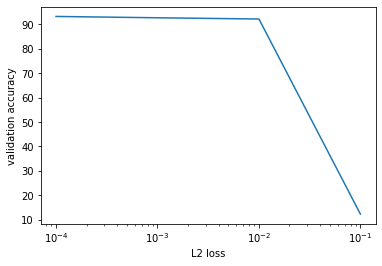

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(list(hyper_scores.keys()), vals)
ax.set_xlabel('L2 loss')
ax.set_ylabel('validation accuracy')
ax.set_xscale('log')

In [9]:
def class_wise_accuracy(dataloader):
    correct = {}
    total = {}
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            for l in range(len(labels)):
                label = int(labels[l].cpu().numpy())
                pred = predicted[l]
                if label in correct:
                    correct[label] += int(pred == label)
                    total[label] += 1
                else:
                    correct[label] = int(pred == label)
                    total[label] = 1
    acc = {}
    for label in correct:
        acc[label] = 100 * correct[label] / total[label]
    return acc

In [10]:
class_wise_accuracy(val_loader)

{8: 100.0, 1: 0.0, 3: 0.0, 6: 0.0, 4: 0.0, 5: 0.0, 7: 0.0, 2: 0.0}